In [1]:
#
# import utilitaires
#
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

import helpers as hlp
import helpers.split as split
import helpers.dataset.PlantVillage as pv
import helpers.features as feat
import helpers.visual_words as vw

In [2]:
#
# parametres
#
executor = hlp.create_thread_pool_executor(max_workers=None)
configs = hlp.get_configs("config_overrides.json", executor)

# pour update tf-idf
configs.orb_bovw.read_only = False
configs.sift_bovw.read_only = False


#
# dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)
print()


#
# train/test
#
train, test = split.load(configs.split)

print("Train size:", len(train))
print("Test size:", len(test))
print()

#
# orb
#
orb_features = feat.load(configs.orb, None)
orb_bovw = vw.load_bovw(configs.orb_bovw, None)

print("ORB features:", orb_features.features.shape)
print("ORB BoVW clusters:", orb_bovw.cluster_centers.shape)
print()


#
# sift
#
sift_features = feat.load(configs.sift, None)
sift_bovw = vw.load_bovw(configs.sift_bovw, None)

print("Sift features:", sift_features.features.shape)
print("Sift BoVW clusters:", sift_bovw.cluster_centers.shape)

Dataset (60343, 4)

Train size: 3711
Test size: 928

ORB features: (20906105, 32)
ORB BoVW clusters: (500, 26)

Sift features: (14382049, 128)
Sift BoVW clusters: (500, 80)


In [3]:
#
# export en batch des visual words orb
#

# pour debugger, s'assurer que le fichier de visual words 
# est detruit a chaque execution de la cellule
if "orb_pv_vw" in locals():
    del orb_pv_vw

with hlp.Profile() as orb_pv_vw_loading:
    orb_pv_vw = vw.load_dataset_vw(configs.orb_dataset_vw,
                                   orb_features,
                                   configs.orb_bovw,
                                   orb_bovw,
                                   train,
                                   test)
    
print(f"ORB PlantVillage Visual Word loading:", orb_pv_vw_loading.round_duration(), "s")
print("ORB PlantVillage Visual Words", orb_pv_vw.vw_freqs.shape)

ORB PlantVillage Visual Word loading: 0.04 s
ORB PlantVillage Visual Words (4639, 500)


In [4]:
# a = np.ravel( orb_bovw.idf )
# b = np.ravel( orb_pv_vw.index_to_vw_freqs["46984"] )
# c = np.multiply(a, b)

# plt.figure( figsize=(10, 6) )

# plt.subplot(311)
# plt.title("idf")
# plt.bar(range(500), a)

# plt.subplot(312)
# plt.title("tf")
# plt.bar(range(500), b)

# plt.subplot(313)
# plt.title("tf-idf")
# plt.bar(range(500), c)

# plt.tight_layout()
# plt.show()

In [5]:
#
# export en batch des visual words sift
#

# pour debugger, s'assurer que le fichier de visual words 
# est detruit a chaque execution de la cellule
if "sift_pv_vw" in locals():
    del sift_pv_vw

with hlp.Profile() as sift_pv_vw_loading:
    sift_pv_vw = vw.load_dataset_vw(configs.sift_dataset_vw, 
                                    sift_features,
                                    configs.sift_bovw,
                                    sift_bovw,
                                    train,
                                    test)

print(f"sift PlantVillage Visual Word loading:", sift_pv_vw_loading.round_duration(), "s")
print("sift PlantVillage Visual Words", sift_pv_vw.vw_freqs.shape)

sift PlantVillage Visual Word loading: 0.03 s
sift PlantVillage Visual Words (4639, 500)


In [6]:
SAMPLES_GRID = (4, 2)
SAMPLES_COUNT = SAMPLES_GRID[0]
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)

def affiche_image(image_indices, visual_words, idf, features, pv_vw):
    x_range = range(visual_words.n_clusters)
    figure, axes = plt.subplots(SAMPLES_GRID[0],
                                SAMPLES_GRID[1],
                                figsize=FIGSIZE,
                                width_ratios=[1, 3])

    for i, image_index in enumerate(image_indices):
        key_points = features.index_to_key_points[str(image_index)][...]
        visual_words_freq = pv_vw.index_to_vw_freqs[str(image_index)][...].flatten()
        tf_idf = np.multiply(idf, visual_words_freq)

        image = pv_dataset.get_image(image_index)
        image_key_points = visual_words.draw_key_points(image, key_points)

        species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
        disease = pv.attribute_prettify(species, disease)
        title = "\n".join([species, disease])

        plt.sca(axes[i, 0])
        plt.gca().set_ylabel(title)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(image_key_points)

        plt.sca(axes[i, 1])
        plt.bar(x_range, tf_idf)

    axes[0, 0].set_title("Key Points")
    axes[0, 1].set_title("tf-idf Visual Words")

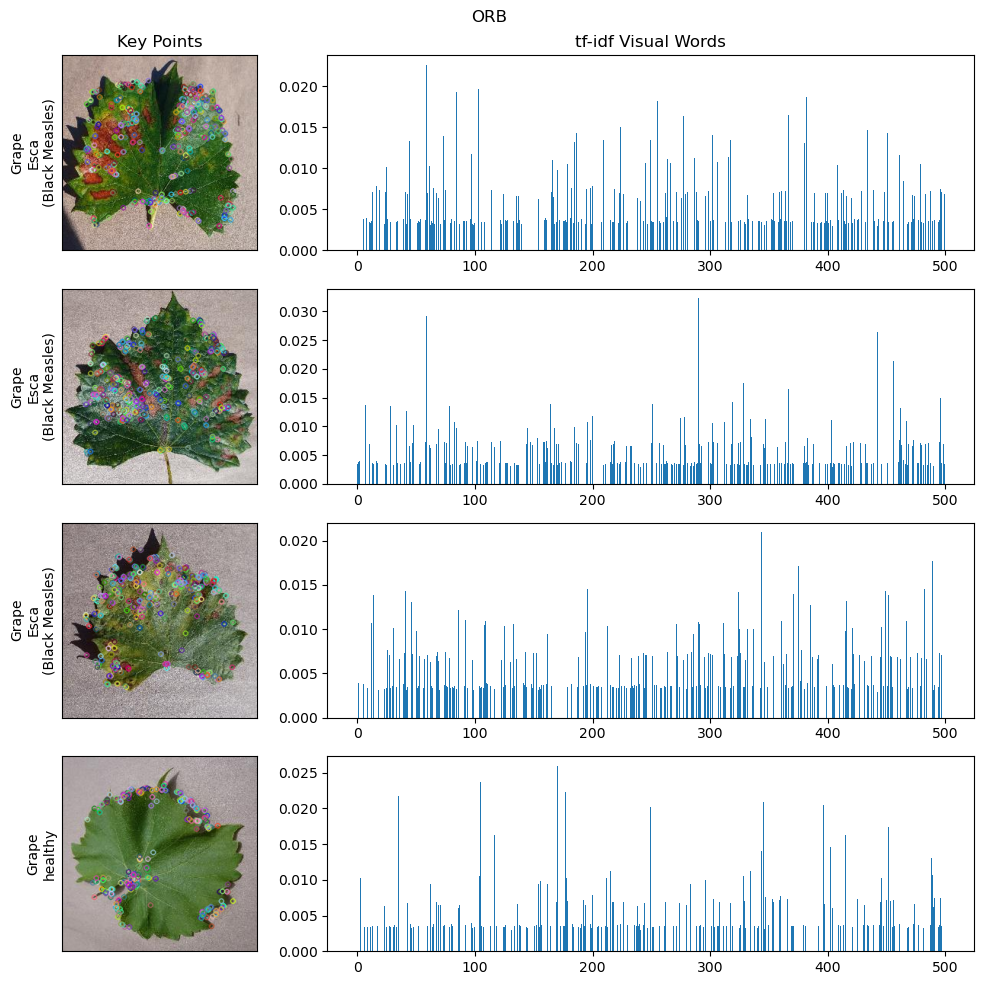

In [7]:
# selectionner quelques images aleatoirement
random.seed(33)
image_indices = random.choices(train, k=SAMPLES_COUNT)
image_indices.sort()

#
# visualiser quelques visual words orb
#
affiche_image(image_indices,
              vw.VisualWords(configs.orb, orb_bovw),
              np.ravel(orb_bovw.idf),
              orb_features, 
              orb_pv_vw)

plt.suptitle("ORB")
plt.tight_layout()
plt.show() 

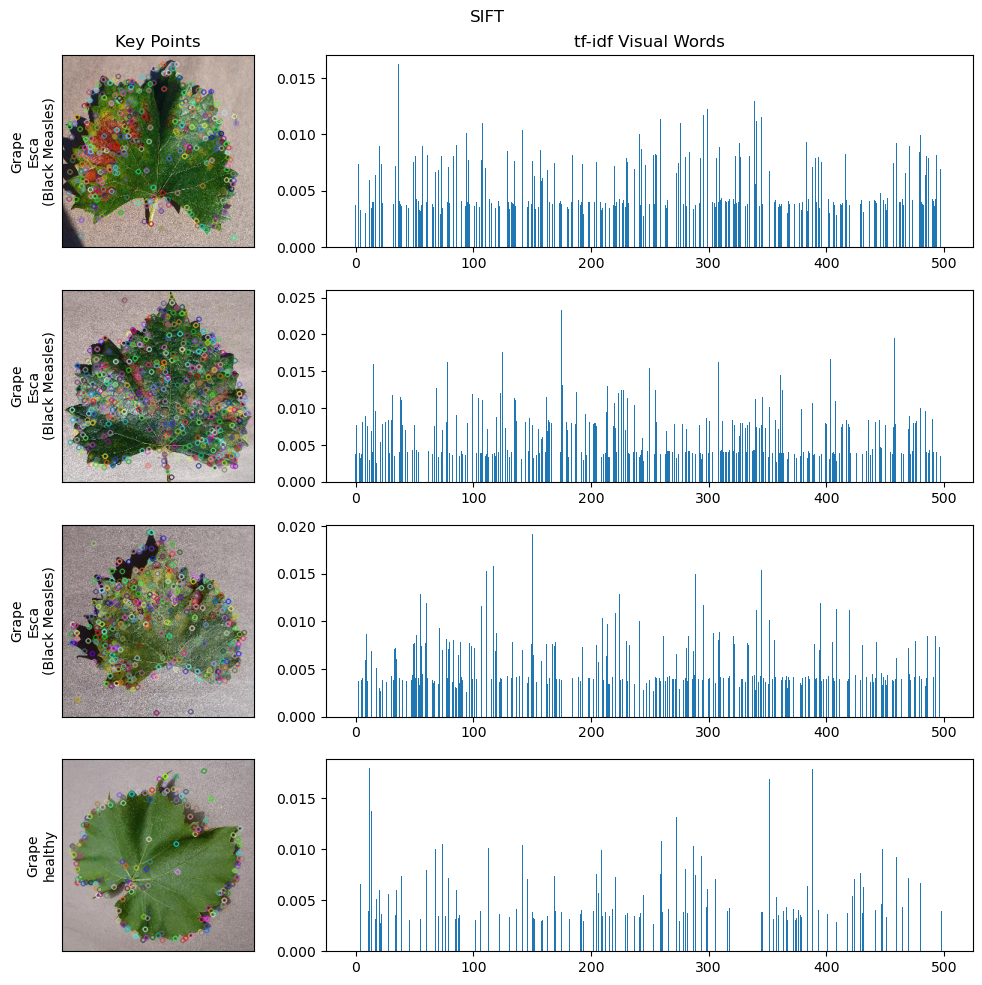

In [8]:
#
# visualiser quelques visual words sift (memes que orb)
#
affiche_image(image_indices,
              vw.VisualWords(configs.sift, sift_bovw), 
              np.ravel(sift_bovw.idf),
              sift_features, 
              sift_pv_vw)

plt.suptitle("SIFT")
plt.tight_layout()
plt.show() 
    
# figure.savefig(f"{vw_title}_visual_words.png")